## Import Library

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from xgboost import XGBRegressor
import os

## Import Data

### Define the path

In [101]:
data_path = os.path.join(os.getcwd(), '..', '..', 'data', 'preprocessed_data.csv')

### Read the csv

In [102]:
df = pd.read_csv(data_path)
df.head()

,bedroom,bathroom,beds,guests,wifi,tv,cable_tv,ac,workspace,hot_water,...,lng,distance_to_coastline,room_name,booking_window,stay_duration_in_days,review_sentiment_score,rating,booking_earned,average_daily_rate,rating_rounded
0,1,1,1,2,1,0,0,1,1,1,...,115.113378,15.6035,Bingin Ombak Apartment - 1 Lantai 1,81,4,0.458603,4.0,5911197.97,1.477799e+06,4.0
1,1,1,1,2,1,0,0,1,1,0,...,115.113378,15.6035,Bingin Ombak Apartment - 2 Lantai 2,81,4,0.458603,4.0,5911197.97,1.477799e+06,4.0
2,1,2,1,2,1,0,0,0,1,0,...,115.113378,15.6035,Standard (PLEASE IGNORE),81,4,0.455450,4.0,5911197.97,1.477799e+06,4.0
3,1,2,1,2,1,0,0,0,1,0,...,115.113378,15.6035,Standard (PLEASE IGNORE),81,4,0.455450,4.0,5911197.97,1.477799e+06,4.0
4,1,3,1,2,1,0,0,0,1,0,...,115.113378,15.6035,Standard (PLEASE IGNORE),81,4,0.452298,4.0,5911197.97,1.477799e+06,4.0


In [103]:
for column_name in df.columns:
    # Get distinct values for each column
    distinct_values = df[column_name].unique()
    
    # Print column name and distinct values
    print("Column Name:", column_name)
    print("Distinct Values:", distinct_values, "\n")

Column Name: bedroom
Distinct Values: [1 2 3 5 4] 

Column Name: bathroom
Distinct Values: [1 2 3 0 5 4] 

Column Name: beds
Distinct Values: [1 2 0 3 5 4] 

Column Name: guests
Distinct Values: [2 4 1 8 0 6 9 3 7] 

Column Name: wifi
Distinct Values: [1 0] 

Column Name: tv
Distinct Values: [0 1] 

Column Name: cable_tv
Distinct Values: [0 1] 

Column Name: ac
Distinct Values: [1 0] 

Column Name: workspace
Distinct Values: [1 0] 

Column Name: hot_water
Distinct Values: [1 0] 

Column Name: parking
Distinct Values: [0 1] 

Column Name: pool
Distinct Values: [0 1] 

Column Name: gym
Distinct Values: [0 1] 

Column Name: private_entrance
Distinct Values: [1 0] 

Column Name: luggage_drop_off
Distinct Values: [1 0] 

Column Name: hanger
Distinct Values: [1 0] 

Column Name: lock
Distinct Values: [1 0] 

Column Name: linens
Distinct Values: [1 0] 

Column Name: garden
Distinct Values: [0 1] 

Column Name: balcony
Distinct Values: [1 0] 

Column Name: kitchen
Distinct Values: [0 1] 

Colu

### Separate features and target variable

In [112]:
X = df.drop(columns=['booking_earned', 'property_name', 'room_name', 
                     'review_sentiment_score', 'rating_rounded'])
y = df['booking_earned']

### Normalize the features

In [113]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Split the normalized data into training and testing sets

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Create XGBoost Model

In [124]:
# Initialize the XGBoost model
model = XGBRegressor(max_depth=7, n_estimators=2000, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
training_mae = mean_absolute_error(y_train, y_pred_train)
print(f'Mean Absolute Error on Training: {training_mae}')

testing_mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Mean Absolute Error on Training: 123.21272145028944
Mean Absolute Error on Testing: 13663.542176680903


### Tuned The Hyperparameter

In [68]:
# Define the model
model = XGBRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.3, 0.4, 0.5],
    'max_depth': [7, 8, 9, 10]
}

# Set up the Grid Search
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=5, 
                           verbose=2, 
                           n_jobs=-1)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Mean Absolute Error: {-best_score}')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.2, max_depth=8, n_estimators=100; total time=   2.1s
[CV] END ...learning_rate=0.2, max_depth=8, n_estimators=100; total time=   2.1s
[CV] END ...learning_rate=0.2, max_depth=8, n_estimators=100; total time=   2.1s
[CV] END ...learning_rate=0.2, max_depth=8, n_estimators=100; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=8, n_estimators=100; total time=   2.2s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=100; total time=   2.6s
[CV] END ...learning_rate=0.2, max_depth=9, n_es

In [69]:
# Define the model
model = XGBRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 1000, 2000, 5000],
    'learning_rate': [0.5],
    'max_depth': [10]
}

# Set up the Grid Search
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=5, 
                           verbose=2, 
                           n_jobs=-1)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Mean Absolute Error: {-best_score}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..learning_rate=0.5, max_depth=10, n_estimators=100; total time=   3.5s
[CV] END ..learning_rate=0.5, max_depth=10, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.5, max_depth=10, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.5, max_depth=10, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.5, max_depth=10, n_estimators=100; total time=   3.0s
[CV] END .learning_rate=0.5, max_depth=10, n_estimators=1000; total time=  42.4s
[CV] END .learning_rate=0.5, max_depth=10, n_estimators=1000; total time=  42.6s
[CV] END .learning_rate=0.5, max_depth=10, n_estimators=1000; total time=  43.1s
[CV] END .learning_rate=0.5, max_depth=10, n_estimators=1000; total time=  43.6s
[CV] END .learning_rate=0.5, max_depth=10, n_estimators=1000; total time=  37.1s
[CV] END .learning_rate=0.5, max_depth=10, n_estimators=2000; total time= 1.0min
[CV] END .learning_rate=0.5, max_depth=10, n_esti

### Cross Validation

In [74]:
# Define your XGBoost model
model = XGBRegressor(learning_rate=0.5, max_depth=10, n_estimators=5000, random_state=42)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = model.predict(X_test)

# Evaluate the model on the test data
testing_mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Cross-Validation MAE Scores: [65906.12252101 90985.81628196 71786.27727205 78295.26142383
 81218.19406268]
Mean Cross-Validation MAE: 77638.33431230616
Mean Absolute Error on Testing: 68728.40530740535


### Feature Important

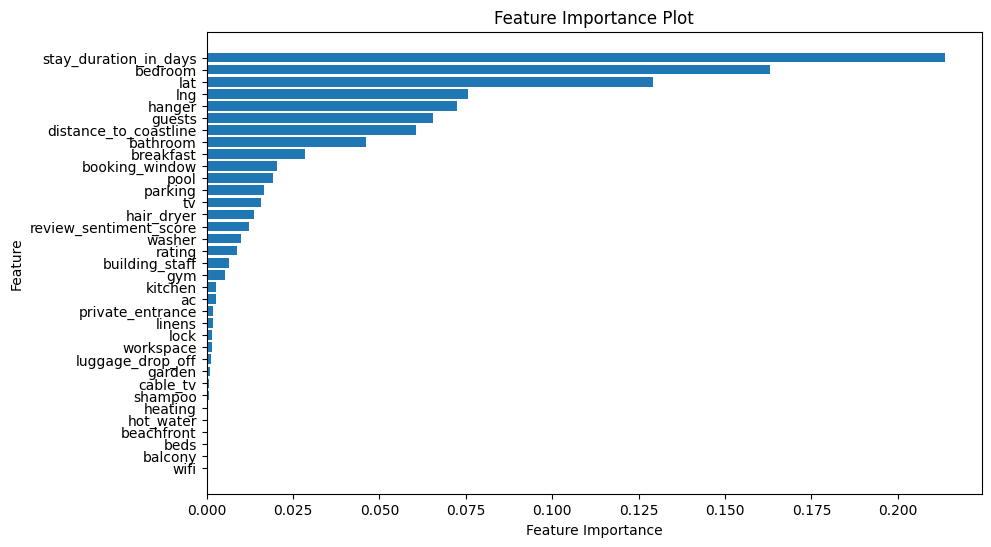

Mean Absolute Error: 68728.40530740535


In [75]:
import matplotlib.pyplot as plt

# Initialize a new XGBoost model with the best hyperparameters
best_model = XGBRegressor(learning_rate=0.5, max_depth=10, n_estimators=5000, random_state=42)

# Train the model on the entire training dataset with the best hyperparameters
best_model.fit(X_train, y_train)

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature importances with corresponding column names
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by feature importance values
fi_df = fi_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

### Predict with Feature Important 

In [76]:
important_column = ['stay_duration_in_days', 'bedroom', 'lat', 'lng', 
                    'hanger', 'guests', 'distance_to_coastline', 'bathroom',
                    'breakfast', 'booking_window', 'pool', 'parking']

X_important = df[important_column]
y_important = df['booking_earned']

In [77]:
scaler = StandardScaler()
X_important_scaled = scaler.fit_transform(X_important)

In [78]:
X_important_train, X_important_test, y_important_train, y_important_test = train_test_split(X_important_scaled, y_important, test_size=0.2, random_state=42)

In [80]:
# Initialize the XGBoost model
model = XGBRegressor(learning_rate=0.5, max_depth=10, n_estimators=5000, random_state=42)

# Fit the model on the training data
model.fit(X_important_train, y_important_train)

# Make predictions on the test data
y_pred_important_train = model.predict(X_important_train)
y_pred_important_test = model.predict(X_important_test)

# Evaluate the model
training_important_mae = mean_absolute_error(y_important_train, y_pred_important_train)
print(f'Mean Absolute Error on Training: {training_important_mae}')

testing_important_mae = mean_absolute_error(y_important_test, y_pred_important_test)
print(f'Mean Absolute Error on Testing: {testing_important_mae}')

Mean Absolute Error on Training: 86421.91422589438
Mean Absolute Error on Testing: 127639.71347742708


### Convert Model to PKL

In [95]:
import joblib

# Your XGBoost model
model = XGBRegressor(max_depth=9, n_estimators=1000, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(model, 'xgboost_model.pkl')

['xgboost_model.pkl']

### Load and test the model

In [96]:
# Load the trained XGBoost model
xgboost_model = joblib.load('xgboost_model.pkl')

# Use XGBoost model to make predictions
xgboost_predictions_test = xgboost_model.predict(X_test)

# Now you can use these predictions in your TensorFlow code
print(xgboost_predictions_test[:10])

[2102673.2  3153108.    800179.6   880620.94 2508162.8  3489051.2
 2097875.8   465960.88 5401827.   1590386.9 ]
